## 기본설정 및 함수정의

#### - 목표 : 
#### 1. 분석 대상지를 중심으로 토지이용계획 별 탄소 배출 및 흡수 요인을 다각도로 분석
#### 2. 분석대상지의 개발계획(토지이용 특성, 산업 및 경제 특성, 인구, 대중교통의 접근성 등)과 탄소 배출 및 흡수 요인의 관계를 분석하고,<br>해당 요인별 가중치를 도출
#### 3. 분석결과는 분석대상지역의 가중치를 고려해 토지이용계획별 1㎡당(또는 1명당) 탄소발생량/흡수량을 계량적 수치로 도출하고 보고서에 포함


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 행정동

In [2]:
# 송파구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_11240_2023_4Q/bnd_dong_11240_2023_4Q.shp"
songpa_gdf = gpd.read_file(shapefile_path1)
songpa_gdf = songpa_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 인천서구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_23080_2023_4Q/bnd_dong_23080_2023_4Q.shp"
incheon_seo_gdf = gpd.read_file(shapefile_path1)
incheon_seo_gdf = incheon_seo_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 성남시 수정구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31021_2023_4Q/bnd_dong_31021_2023_4Q.shp"
sungnam_soojung_gdf = gpd.read_file(shapefile_path1)
sungnam_soojung_gdf = sungnam_soojung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# # 성남시 중원구 행정동 데이터
# shapefile_path1 = "SBJ_2504_001/bnd_dong_31022_2023_4Q/bnd_dong_31022_2023_4Q.shp"
# sungnam_jungwon_gdf = gpd.read_file(shapefile_path1)
# sungnam_jungwon_gdf = sungnam_jungwon_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# # 성남시 분당구 행정동 데이터
# shapefile_path1 = "SBJ_2504_001/bnd_dong_31023_2023_4Q/bnd_dong_31023_2023_4Q.shp"
# sungnam_bundang_gdf = gpd.read_file(shapefile_path1)
# sungnam_bundang_gdf = sungnam_bundang_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  하남시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31180_2023_4Q/bnd_dong_31180_2023_4Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  화성시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31240_2023_4Q/bnd_dong_31240_2023_4Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path1)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 광명시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31060_2023_4Q/bnd_dong_31060_2023_4Q.shp"
gwangmyung_gdf = gpd.read_file(shapefile_path1)
gwangmyung_gdf = gwangmyung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 시흥시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31150_2023_4Q/bnd_dong_31150_2023_4Q.shp"
siheung_gdf = gpd.read_file(shapefile_path1)
siheung_gdf = siheung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 필요한 GeoDataFrame들을 리스트로 묶어서 병합
gdf_list = [
    songpa_gdf, incheon_seo_gdf, sungnam_soojung_gdf,
    hanam_gdf, hwasung_gdf, gwangmyung_gdf, siheung_gdf
]

# 하나의 GeoDataFrame으로 통합
merged_area_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs="EPSG:4326")

##### 분석대상지 격자

In [3]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/09. 격자(분석대상지).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_analyze = pd.json_normalize(geojson_data['features'])
grid_analyze['geometry'] = grid_analyze['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_analyze.drop(columns="geometry.coordinates", axis=1, inplace=True)
# grid_analyze 데이터프레임을 GeoDataFrame으로 변환
grid_analyze = gpd.GeoDataFrame(grid_analyze, geometry='geometry')
grid_analyze_dict = dict(zip(grid_analyze['properties.gid'], grid_analyze['geometry']))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type']
grid_analyze = grid_analyze.drop(columns=drop_cols)

# 'properties.' 접두사 제거
grid_analyze.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in grid_analyze.columns
]

grid_analyze = grid_analyze.drop_duplicates(subset='gid', keep='first')

# 격자와 도시공간의 공간 교차
grid_analyze = gpd.sjoin(grid_analyze, merged_area_gdf, how='inner', predicate='intersects')

# 필요 없는 열 제거 (sjoin 결과에는 index_right 등 추가됨)
grid_analyze = grid_analyze.drop(columns=["index_right"])
grid_analyze = grid_analyze.drop_duplicates(['gid'], keep='last')
grid_analyze = grid_analyze[['gbn', 'gid', 'geometry']].reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_14824\193309658.py:24: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [ ]:
# 맵 객체 생성 및 데이터 로드
grid_map = KeplerGl(height=1000, width=1500)
grid_map.add_data(data=grid_analyze, name="격자 데이터")

# 맵 출력 및 상세설정
grid_map

In [ ]:
# 맵 저장
# grid_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자거주인구 map.html")

Map saved to visualization/화성시 현황/화성시 격자거주인구 map.html!


#### 격자인구통계

In [4]:
respop_df = pd.read_csv('SBJ_2504_001/01. 성연령별_거주인구(격자).csv')

#grid ID 리스트 와 매핑 & respop_df 필터링
grid_id = grid_analyze['gid'].tolist() # gid는 전부 unique한 값
grid_respop = respop_df[respop_df['gid'].isin(grid_id)]
grid_respop = grid_respop.fillna(0)
grid_respop = pd.concat([grid_respop.iloc[:, :2], grid_respop.iloc[:, 2:].astype(int)], axis=1)
grid_respop['year'] = grid_respop['year'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gbn', 'gid', 'year']
for i in range(3, len(grid_respop.columns)):
    age = f'{grid_respop.columns[i][2:4]}대' if grid_respop.columns[i][2] != '1' else f'{grid_respop.columns[i][2:5]}대'
    sex = '남' if grid_respop.columns[i][0] != 'm' else '여'
    columns.append('%s_%s'%(age, sex))
grid_respop.columns = columns
# 인구 column 생성
grid_respop['거주인구'] = grid_respop.iloc[:, 3:].sum(axis=1)

# 연령대별로 성별 통합
grid_respop['20대'] = grid_respop['20대_여'] + grid_respop['20대_남']
grid_respop['30대'] = grid_respop['30대_여'] + grid_respop['30대_남']
grid_respop['40대'] = grid_respop['40대_여'] + grid_respop['40대_남']
grid_respop['50대'] = grid_respop['50대_여'] + grid_respop['50대_남']
grid_respop['60대'] = grid_respop['60대_여'] + grid_respop['60대_남']
grid_respop['70대'] = grid_respop['70대_여'] + grid_respop['70대_남']
grid_respop['80대'] = grid_respop['80대_여'] + grid_respop['80대_남']
grid_respop['90대'] = grid_respop['90대_여'] + grid_respop['90대_남']
grid_respop['100대'] = grid_respop['100대_여'] + grid_respop['100대_남']

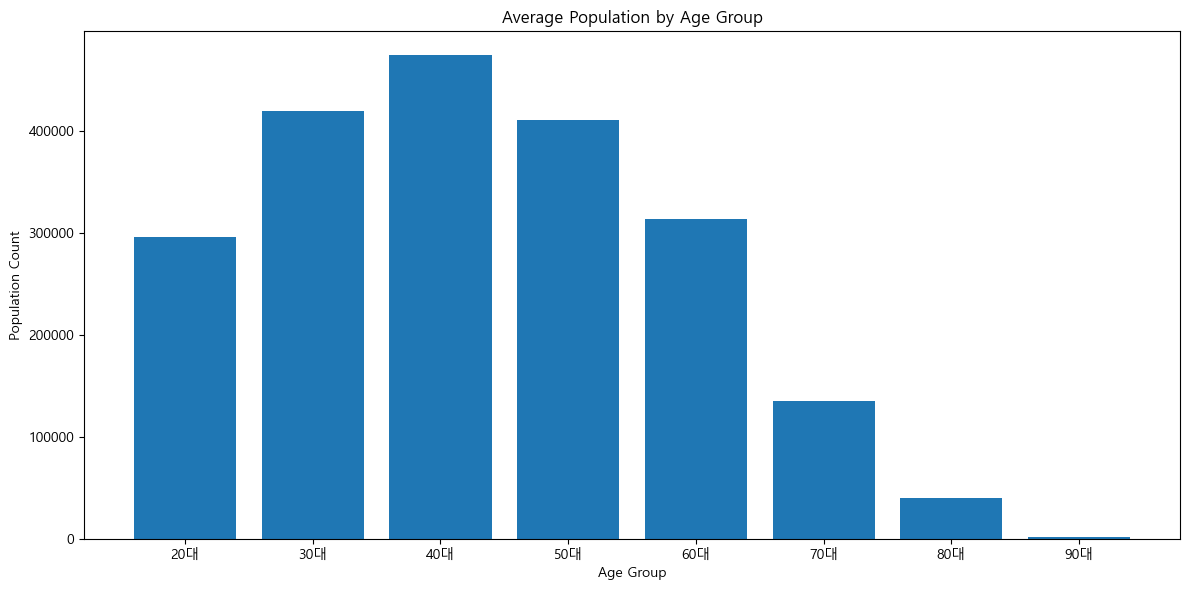

In [5]:
# 필요한 열만 선택
age_totals = grid_respop[['year', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대']]

# 데이터프레임을 긴 형식으로 변환
age_totals_melted = age_totals.melt(id_vars='year', var_name='Age Group', value_name='Count')

# 연도별 연령대 분포 계산
age_totals_yearly = age_totals_melted[['Age Group', 'Count']].groupby(['Age Group']).sum().reset_index()
# 100대 연령대 제거
age_totals_yearly = age_totals_yearly[age_totals_yearly['Age Group'] != '100대']

# 나이 그룹과 카운트 추출
age_groups = age_totals_yearly['Age Group']
counts = age_totals_yearly['Count']

# 그래프 사이즈 설정
plt.figure(figsize=(12, 6))

# 기본 색상으로 바 차트 생성
plt.bar(age_groups, counts)

# 레이블 및 타이틀 설정
plt.xlabel('Age Group')
plt.ylabel('Population Count')
plt.title('Average Population by Age Group')
plt.xticks(rotation=0)  # 레이블 수평 유지

# 시각화 출력
plt.tight_layout()
plt.show()

In [6]:
# 거주인구 - 격자에 mapping작업
grid_respop = grid_respop[['gbn', 'gid', '거주인구']]

# 생성된 map_dic에 filtered_respop의 gid를 매핑하여 'geometry' column 생성
geometry_lst = []
for _, row in tqdm(grid_respop.iterrows()):
    geometry_lst.append(grid_analyze_dict[row['gid']])
grid_respop['geometry'] = geometry_lst
grid_respop = gpd.GeoDataFrame(grid_respop, geometry='geometry')

# 분석대상지에 매핑하기
grid_result = pd.merge(grid_analyze, grid_respop[['gid', '거주인구']], on='gid', how='left')

# gid와 geometry 기준으로 groupby하고 거주인구 합산
grid_result = grid_result.groupby(['gid', 'geometry'], as_index=False)['거주인구'].sum()
grid_result = gpd.GeoDataFrame(grid_result, geometry='geometry')

101786it [00:07, 14286.97it/s]


In [ ]:
# 맵 객체 생성 및 데이터 로드
grid_map = KeplerGl(height=1000, width=1500)
grid_map.add_data(data=grid_respop, name="격자거주인구 데이터")

# 맵 출력 및 상세설정
grid_map

#### 유동인구

In [7]:
# 유동인구 df 로드
floating_population_df = pd.read_csv('SBJ_2504_001/05._성연령별_유동인구.csv')
floating_population_df['STD_YM'] = floating_population_df['STD_YM'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gbn', 'year']
for i in range(2, 14):
    floating_population_df[floating_population_df.columns[i]] = floating_population_df[floating_population_df.columns[i]].astype(float)
    new_col = f'{floating_population_df.columns[i][2:4]}대_남' if floating_population_df.columns[i][0] == 'm' else f'{floating_population_df.columns[i][2:4]}대_여'
    columns.append(new_col)
floating_population_df.columns = columns + floating_population_df.columns[14:16].tolist()
floating_population_df['총합'] = floating_population_df.iloc[:, 2:-2].sum(axis=1)
floating_population_df['year'] = floating_population_df['year'].apply(lambda x : x[2:])
floating_population_df = geo_transform(floating_population_df)

col_lst = ['gbn', 'year'] + list(floating_population_df.columns[-2:]) + ['총합']
floating_population_df = floating_population_df[col_lst]

floating_pop = gpd.sjoin(floating_population_df, grid_analyze, how='inner', op='within')

floating_pop['year'] = "20" + floating_pop['year'].astype(str).str[:2]
floating_pop['year'] = floating_pop['year'].astype(int)

# 필요한 열만 남기기
floating_pop = floating_pop.rename(columns={'properties.gid': 'gid'})
floating_pop = floating_pop[['gbn_left', 'gid', '총합', 'geometry']]
floating_pop = floating_pop.rename(columns={'gbn_left': 'gbn'})
floating_pop = pd.concat([floating_pop.iloc[:,:3], floating_pop.iloc[:,-1:]], axis=1)
floating_pop  = gpd.GeoDataFrame(floating_pop , geometry='geometry')

# 그룹화 및 집계 수행
floating_pop  = floating_pop.dissolve(
    by=['gbn', 'gid'],
    aggfunc={'총합': 'sum'}
).reset_index()

floating_pop ['geometry'] = floating_pop ['gid'].map(grid_analyze_dict)
floating_pop  = gpd.GeoDataFrame(floating_pop , geometry='geometry')
floating_pop = floating_pop.rename(columns={'총합': '유동인구'})

# 분석대상지에 매핑하기
grid_result = pd.merge(grid_result, floating_pop[['gid', '유동인구']], on='gid', how='left')

# gid와 geometry 기준으로 groupby하고 거주인구 합산
grid_result = grid_result.groupby(['gid', 'geometry'], as_index=False)[['거주인구', '유동인구']].sum()
grid_result = gpd.GeoDataFrame(grid_result, geometry='geometry')

100%|██████████| 3734223/3734223 [02:22<00:00, 26240.84it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Te

In [ ]:
# 맵 객체 생성 및 데이터 로드
floatingpop_map = KeplerGl(height=1000, width=1500)
floatingpop_map.add_data(data=floating_pop, name="유동인구 데이터")

floatingpop_map

#### 상권 접근성(행정구역별로 구분해서 도출)

In [8]:
# 각 도시 면적 계산 후 면적 기준으로 top_n, min_distance_km 설정
# 성남시: 수정구 (중원구, 분당구 미포함)
sungnam_gdfs = [
    gpd.read_file("SBJ_2504_001/bnd_dong_31021_2023_4Q/bnd_dong_31021_2023_4Q.shp"),
    # gpd.read_file("SBJ_2504_001/bnd_dong_31022_2023_4Q/bnd_dong_31022_2023_4Q.shp"),
    # gpd.read_file("SBJ_2504_001/bnd_dong_31023_2023_4Q/bnd_dong_31023_2023_4Q.shp")
]
sungnam_gdf = pd.concat(sungnam_gdfs).to_crs(epsg=5179)  # meters-based 좌표계로 변환
area_sungnam = sungnam_gdf.geometry.area.sum() / 1e6  # km²로 변환

# 하남시
hanam_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_31180_2023_4Q/bnd_dong_31180_2023_4Q.shp").to_crs(epsg=5179)
area_hanam = hanam_gdf.geometry.area.sum() / 1e6

# 화성시
hwasung_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_31240_2023_4Q/bnd_dong_31240_2023_4Q.shp").to_crs(epsg=5179)
area_hwasung = hwasung_gdf.geometry.area.sum() / 1e6

# 송파구
songpa_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_11240_2023_4Q/bnd_dong_11240_2023_4Q.shp").to_crs(epsg=5179)
area_songpa = songpa_gdf.geometry.area.sum() / 1e6

# 인천 서구
incheon_seo_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_23080_2023_4Q/bnd_dong_23080_2023_4Q.shp").to_crs(epsg=5179)
area_incheon_seo = incheon_seo_gdf.geometry.area.sum() / 1e6

In [9]:
# 도시별 면적 딕셔너리
area_dict = {
    '경기도 성남시': area_sungnam,
    '경기도 하남시': area_hanam,
    '경기도 화성시': area_hwasung,
    '서울특별시 송파구': area_songpa,
    '인천광역시 서구': area_incheon_seo,
}

def get_kde_params(area_km2, base_area=100, base_top_n=10, base_distance=2, max_top_n=10):
    """
    도시 면적을 기준으로 KDE 파라미터(top_n, min_distance_km)를 설정
    - top_n은 log1p 비율 기반으로 증가
    - min_distance_km은 sqrt 기반 증가
    - 둘 다 상한선 설정 가능
    """
    ratio = area_km2 / base_area

    # log 기반 완화 증가, 최소 5개 이상, 최대 max_top_n 제한
    top_n = min(max_top_n, max(5, int(base_top_n * np.log1p(ratio))))

    # 거리 기준은 면적의 sqrt 비례 증가
    min_dist = round(base_distance * np.sqrt(ratio), 1)

    return top_n, min_dist

# 도시별 매개변수 계산
param_dict = {}
for city, area in area_dict.items():
    top_n, min_dist = get_kde_params(area)
    param_dict[city] = {'top_n': top_n, 'min_distance_km': min_dist}

# 확인
from pprint import pprint
pprint(param_dict)

from scipy.stats import gaussian_kde
from geopy.distance import geodesic

business_area_data = pd.read_csv('SBJ_2504_001/02. 상권정보.csv')
business_area_data = geo_transform(business_area_data)

# 나눌 기준이 되는 지역 리스트로 지역별 데이터프레임을 담을 딕셔너리 생성
region_list = ['경기도 성남시', '경기도 하남시', '경기도 화성시', '서울특별시 송파구', '인천광역시 서구']
region_dfs = {}

# 각 지역에 대해 필터링하여 별도 DataFrame 생성
for region in region_list:
    region_dfs[region] = business_area_data[business_area_data['gbn'] == region]

{'경기도 성남시': {'min_distance_km': 1.3, 'top_n': 5},
 '경기도 하남시': {'min_distance_km': 1.9, 'top_n': 6},
 '경기도 화성시': {'min_distance_km': 5.6, 'top_n': 10},
 '서울특별시 송파구': {'min_distance_km': 1.2, 'top_n': 5},
 '인천광역시 서구': {'min_distance_km': 2.3, 'top_n': 8}}


100%|██████████| 108963/108963 [00:05<00:00, 19331.25it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6




▶ 경기도 성남시 - top_n: 5, min_distance_km: 1.3


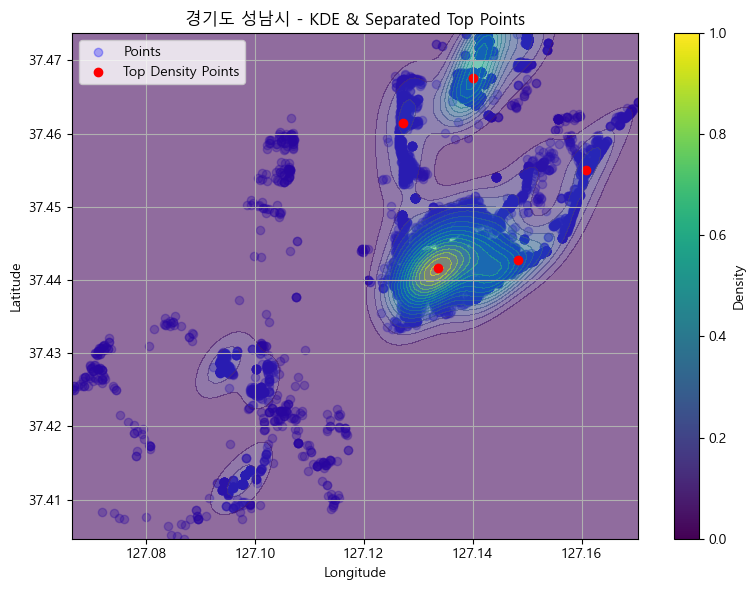


▶ 경기도 하남시 - top_n: 6, min_distance_km: 1.9


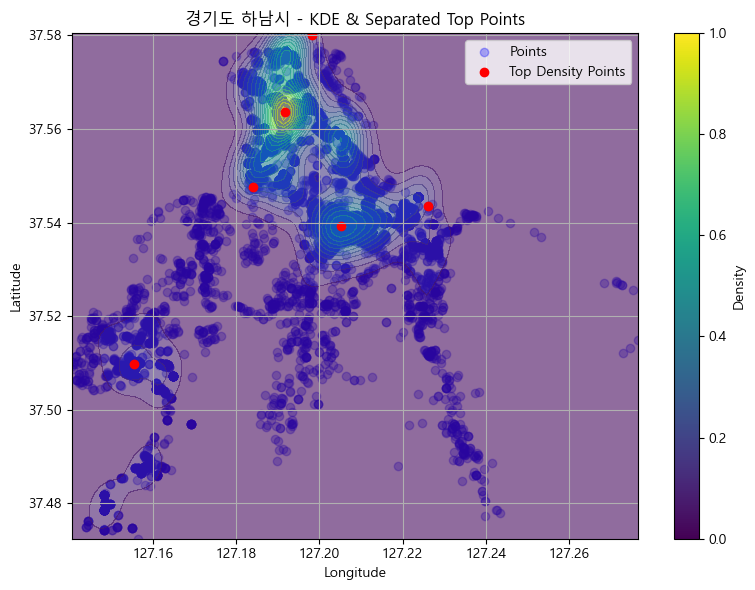


▶ 경기도 화성시 - top_n: 10, min_distance_km: 5.6


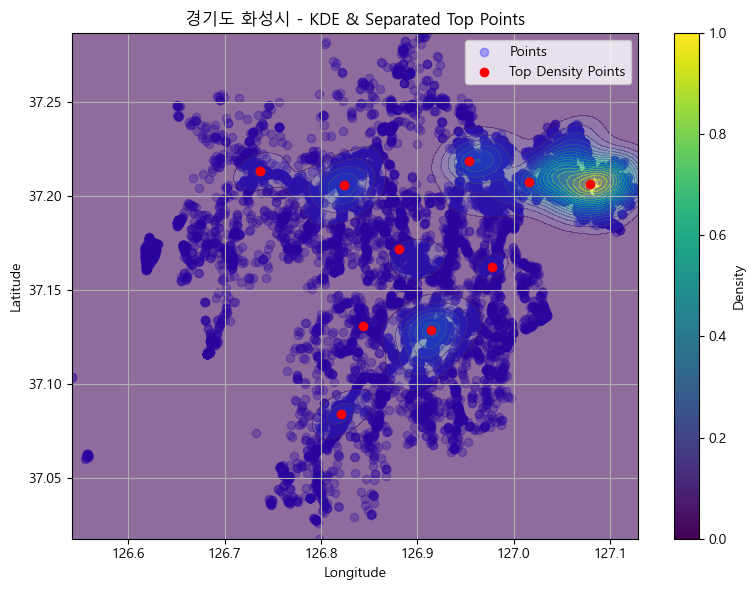


▶ 서울특별시 송파구 - top_n: 5, min_distance_km: 1.2


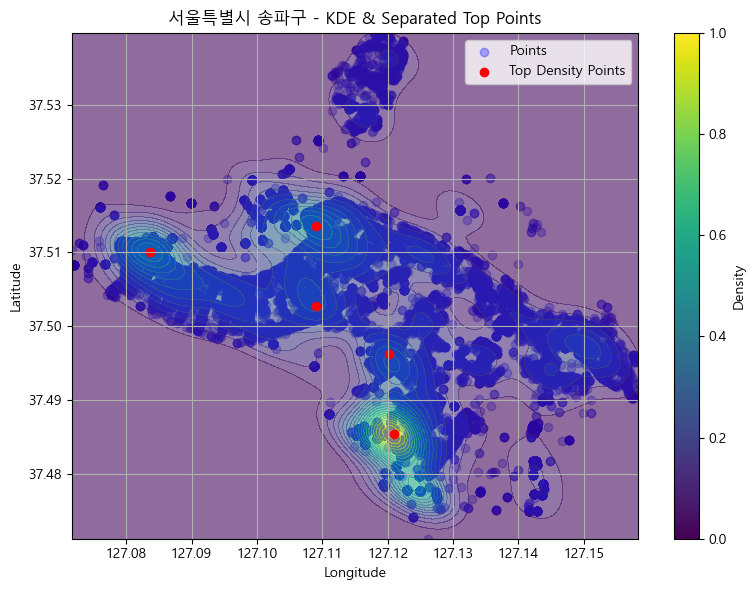


▶ 인천광역시 서구 - top_n: 8, min_distance_km: 2.3


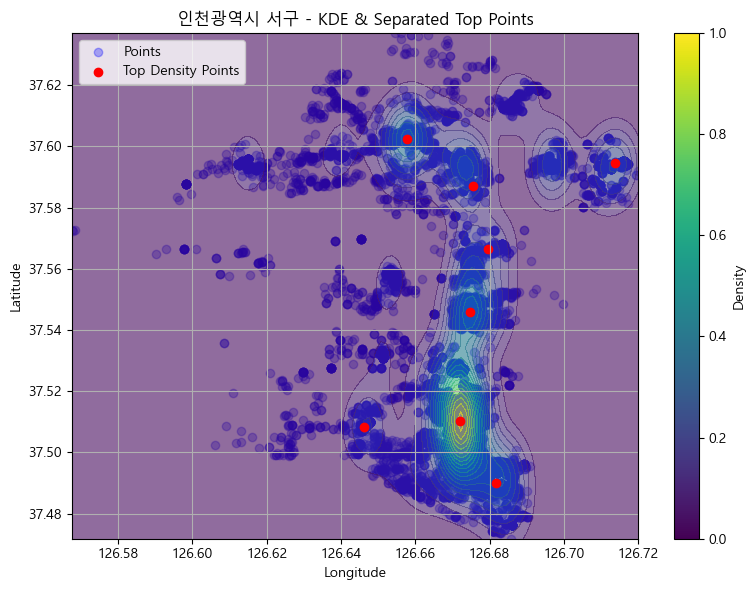

In [10]:
def find_separated_density_points(data, lon_col='lon', lat_col='lat', top_n=10, min_distance_km=1):
    coords = data[[lon_col, lat_col]].values.T  # (2, N)

    kde = gaussian_kde(coords)
    density = kde(coords)
    data = data.copy()
    data['density'] = density
    data = data.sort_values('density', ascending=False).reset_index(drop=True)

    selected_points = []
    remaining_points = data.copy()

    MAX_POINTS = 10

    while len(selected_points) < min(top_n, MAX_POINTS) and not remaining_points.empty:
        top_point = remaining_points.iloc[0]
        selected_points.append(top_point)

        remaining_points['distance'] = remaining_points.apply(
            lambda row: geodesic(
                (top_point[lat_col], top_point[lon_col]),
                (row[lat_col], row[lon_col])
            ).km,
            axis=1
        )

        remaining_points = remaining_points[remaining_points['distance'] > min_distance_km].reset_index(drop=True)

    selected_points_df = pd.DataFrame(selected_points)
    return selected_points_df, kde


def plot_separated_density_map(data, kde, top_points, region_name, lon_col='lon', lat_col='lat', resolution=100):
    x = np.linspace(data[lon_col].min(), data[lon_col].max(), resolution)
    y = np.linspace(data[lat_col].min(), data[lat_col].max(), resolution)
    X, Y = np.meshgrid(x, y)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(grid_coords).reshape(X.shape)

    plt.figure(figsize=(8, 6))
    plt.scatter(data[lon_col], data[lat_col], c='blue', alpha=0.3, label='Points')
    plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
    plt.scatter(top_points[lon_col], top_points[lat_col], color='red', label='Top Density Points')
    plt.colorbar(label='Density')
    plt.title(f'{region_name} - KDE & Separated Top Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_kde_for_all_regions(region_dfs, param_dict):
    results = {}
    for region_name, df in region_dfs.items():
        if region_name not in param_dict:
            print(f"[{region_name}] 파라미터 없음, 스킵합니다.")
            continue

        params = param_dict[region_name]
        top_n = params['top_n']
        min_distance = params['min_distance_km']

        print(f"\n▶ {region_name} - top_n: {top_n}, min_distance_km: {min_distance}")
        top_points, kde = find_separated_density_points(df, top_n=top_n, min_distance_km=min_distance)
        plot_separated_density_map(df, kde, top_points, region_name)
        results[region_name] = top_points


    return results  # 각 도시별로 top_points 저장된 딕셔너리 반환

# param_dict, region_dfs를 바탕으로 실행
all_top_points = run_kde_for_all_regions(region_dfs, param_dict)

In [11]:
# 각 격자별로 가장 가까운 번화가(상권밀집지)까지의 거리 구하기
# 격자 중심점 좌표 추출
grid_result = grid_result.copy()
grid_result['centroid'] = grid_result['geometry'].centroid
grid_result['centroid_coords'] = grid_result['centroid'].apply(lambda p: (p.y, p.x))  # (lat, lon)

# 번화가 중심점 리스트 추출 (모든 지역 통합 기준)
# all_top_points는 {'도시명': DataFrame} 형태라고 가정
all_points = []
for df in all_top_points.values():
    if 'geometry' in df.columns:
        all_points.extend([(p.y, p.x) for p in df['geometry']])
    else:
        all_points.extend(list(zip(df['lat'], df['lon'])))

# 가장 가까운 번화가까지의 거리 계산 함수
def min_dist_to_hotspot(coord):
    return min([geodesic(coord, hotspot).km for hotspot in all_points])

# 거리 계산
grid_result['dist_to_hotspot_km'] = grid_result['centroid_coords'].progress_apply(min_dist_to_hotspot)
grid_result.drop(columns=['centroid', 'centroid_coords'], inplace=True)

100%|██████████| 101608/101608 [17:37<00:00, 96.08it/s] 


#### 도시잠재력지표

In [12]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/04._도시잠재력지표.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
city_pot = pd.json_normalize(geojson_data['features'])
city_pot['geometry'] = city_pot['geometry.coordinates'].apply(lambda x : make_point(x))
city_pot = gpd.GeoDataFrame(city_pot, geometry='geometry')

# 제거할 열 리스트
drop_cols = ['type', 'properties.fid', 'properties.sido_cd', 'properties.sgg_cd', 'geometry.type', 'geometry.coordinates']
city_pot = city_pot.drop(columns=drop_cols)

# 'properties.' 접두사 제거
city_pot.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in city_pot.columns
]

rename_dict = {
    'ps_01': '기개발지 접근',
    'ps_02': '시군구청 접근',
    'ps_03': '공공편의시설 접근',
    'ps_04': '지장물 현황',
    'ps_05': '고속도로IC 접근',
    'ps_06': '간선도로 접근',
    'ps_07': '철도역사 접근',
    'ps_08': '여객터미널 접근',
    'ps_09': '피복분류',
    'ps_10': '용도지역',
    'ps_11': '인허가',
    'ps_12': '지역내 총생산',
    'ps_13': '지가경쟁력',
    'ps_14': '지가수준',
    'ps_15': '지가변동률',
    'ps_16': '인구증감률',
    'ps_17': '인구밀도',
    'ps_18': '경제활동인구수',
    'ps_19': '세대증감률',
    'ps_20': '사업체수',
    'ps_21': '주택보급률',
    'ps_22': '등록공장현황',
    'ps_23': '국공유지',
    'ps_24': '표고',
    'ps_25': '경사도',
    'ps_26': '국토환경성평가',
}

# 열 이름 변경
city_pot.rename(columns=rename_dict, inplace=True)
city_pot = city_pot[['gbn', '기개발지 접근', '시군구청 접근', '공공편의시설 접근', '고속도로IC 접근',
       '간선도로 접근', '철도역사 접근', '여객터미널 접근', '피복분류',
       '지가경쟁력', '지가수준', 'geometry']]

joined = gpd.sjoin(city_pot, grid_analyze[['gid', 'geometry']], how='inner', predicate='within')

# 각 지표별로 집계 방식 지정
agg_dict = {
    '기개발지 접근': 'mean',
    '시군구청 접근': 'mean',
    '공공편의시설 접근': 'mean',
    '고속도로IC 접근': 'mean',
    '간선도로 접근': 'mean',
    '철도역사 접근': 'mean',
    '여객터미널 접근': 'mean',
    '피복분류': 'mean',
    '지가경쟁력': 'mean',
    '지가수준': 'mean',
}

# 집계 수행
agg_df = joined.groupby('gid').agg(agg_dict).reset_index()

# 4. 집계 결과를 grid_analyze에 병합
grid_result = grid_result.merge(agg_df, on='gid', how='left')

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# 보간 대상 열 리스트
target_columns = list(agg_dict.keys())

# 격자 중심좌표(x, y) 생성
grid_result = grid_result.copy()
grid_result['x'] = grid_result.geometry.centroid.x
grid_result['y'] = grid_result.geometry.centroid.y

# 원본 유지한 보간용 복사본
grid_interp = grid_result.copy()

# 열별로 KNN 보간 수행 (원래 NaN이었던 값만 대상)
for col in tqdm(target_columns):
    missing_mask = grid_result[col].isna()  # 원본에서 NaN인 경우만 대상으로

    if missing_mask.sum() == 0:
        continue  # 결측 없으면 스킵

    # 학습용 데이터
    X_train = grid_interp.loc[~missing_mask, ['x', 'y']]
    y_train = grid_interp.loc[~missing_mask, col]

    # 예측 대상
    X_pred = grid_interp.loc[missing_mask, ['x', 'y']]

    # KNN 보간
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
    y_pred = knn.fit(X_train, y_train).predict(X_pred)

    # 예측값 반영
    grid_interp.loc[missing_mask, col] = y_pred

# 결과 반영 및 정리
grid_result[target_columns] = grid_interp[target_columns]
grid_result.drop(columns=['x', 'y'], inplace=True)

100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


#### 상세 도로망

In [79]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/17._주요도로망_네트워크.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : make_lin(x))
roadsystem_df['properties.k_link_id'] = roadsystem_df['properties.k_link_id'].astype(str)
roadsystem_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')

# 'properties.' 접두사 제거
roadsystem_df.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in roadsystem_df.columns
]
roadsystem_df = roadsystem_df.rename(columns={'k_link_id': 'link_id', 'k_length': 'length'})
roadsystem_df = roadsystem_df[['link_id', 'geometry', 'fnode_id', 'tnode_id', 'road_rank', 'road_name', 'link_type', 'lane', 'length']]

#### 도로망에 관련데이터 매핑

In [ ]:
# 도로 id와 geometry를 매핑한 딕셔너리 생성 : 추정교통량 data와 매핑 예정
road_geo_dic = dict(zip(roadsystem_df['link_id'], roadsystem_df['geometry']))
# 도로 id와 lanes를 매핑한 딕셔너리 생성
road_lanes_dic = dict(zip(roadsystem_df['link_id'], roadsystem_df['lane']))
# 도로 id와 fnode_id를 매핑한 딕셔너리 생성
road_fnode_dic = dict(zip(roadsystem_df['link_id'], roadsystem_df['fnode_id']))
# 도로 id와 tnode_id를 매핑한 딕셔너리 생성
road_tnode_dic = dict(zip(roadsystem_df['link_id'], roadsystem_df['tnode_id']))

#혼잡 빈도 & 시간 강도 매핑
con_fre = pd.read_csv('SBJ_2504_001/19._혼잡빈도강도.csv')
con_fre['link_id'] = con_fre['link_id'].astype(str)
road_con_fre_dic = dict(zip(con_fre['link_id'], con_fre['FRIN_CG']))

con_tm = pd.read_csv('SBJ_2504_001/20._혼잡시간강도.csv')
con_tm['link_id'] = con_tm['link_id'].astype(str)
road_con_tm_dic = dict(zip(con_tm['link_id'], con_tm['TI_CG']))

#평균속도 매핑
aver_vel = pd.read_csv('SBJ_2504_001/33._평균속도.csv')
aver_vel = aver_vel[aver_vel['timeslot'] == 'all']
aver_vel['link_id'] = aver_vel['link_id'].astype(str)
road_aver_vel_dic = dict(zip(aver_vel['link_id'], aver_vel['velocity_AVRG']))

traffic_df = pd.read_csv('SBJ_2504_001/18._추정교통량.csv')
traffic_df['link_id'] = traffic_df['link_id'].astype(str)
traffic_df = traffic_df[traffic_df['timeslot'] == 'all'] # 일별 누적교통량 사용
traffic_df['lane'] = traffic_df['link_id'].map(road_lanes_dic)
traffic_df['geometry'] = traffic_df['link_id'].map(road_geo_dic)
traffic_df['fnode_id'] = traffic_df['link_id'].map(road_fnode_dic)
traffic_df['tnode_id'] = traffic_df['link_id'].map(road_tnode_dic)
traffic_df['혼잡빈도강도'] = traffic_df['link_id'].map(road_con_fre_dic)
traffic_df['혼잡시간강도'] = traffic_df['link_id'].map(road_con_tm_dic)
traffic_df['평균속도'] = traffic_df['link_id'].map(road_aver_vel_dic)
traffic_df = gpd.GeoDataFrame(traffic_df, geometry='geometry')
traffic_df = traffic_df.rename(columns={'road_length': 'length', 'k_length': 'length'})
traffic_df = traffic_df[['link_id', 'geometry', 'road_rank', 'road_name', 'fnode_id', 'tnode_id', 'lane', 'length', 'ALL_AADT', 'PSCR_AADT', 'BUS_AADT', 'FGCR_AADT', '혼잡빈도강도', '혼잡시간강도', '평균속도']]
traffic_df = traffic_df.dropna(subset = ['geometry']).reset_index(drop=True)

In [132]:
# 도로등급별 기준용량 (대/일/차로)
capacity_dict = {
    '고속국도': 2200,            # '고속도로' → 실제 등급명 '고속국도'
    '고속도로 연결램프': 1500,
    '도시고속국도': 2000,        # '도시고속도로' → 실제 등급명 '도시고속국도'
    '일반국도': 2000,
    '지방도': 1600,
    '시군도': 1200,
    '특별광역시도': 1500,
    '국가지원지방도': 1800      # 가장 유사한 용량 배정
}

# 기준용량 매핑
traffic_df['기준용량'] = traffic_df['road_rank'].map(capacity_dict).fillna(1500)

# 혼잡도 계산
traffic_df['혼잡도'] = traffic_df['ALL_AADT'] / (
    traffic_df['lane'] * traffic_df['length'] * traffic_df['기준용량']
)

# 가중혼잡도 계산
traffic_df['가중혼잡도'] = traffic_df['혼잡도'] * traffic_df['length']

# 혼잡도 및 기준용량 열 제거, 가중혼잡도만 남기기
traffic_df.drop(columns=['혼잡도', '기준용량'], inplace=True)

In [133]:
traffic_df

,link_id,geometry,road_rank,road_name,fnode_id,tnode_id,lane,length,ALL_AADT,PSCR_AADT,BUS_AADT,FGCR_AADT,혼잡빈도강도,혼잡시간강도,가중혼잡도
0,1062599,"LINESTRING (126.91484 37.06922, 126.91505 37.0...",일반국도,서해로,552952.0,553018.0,4.0,0.074,19001.182,12599.686,166.915,6234.581,59.78,67.63,2.375148
1,8910107,"LINESTRING (126.74573 37.24909, 126.74570 37.2...",지방도,공룡로,1720697.0,1720700.0,1.0,0.037,7440.458,5779.291,122.059,1539.108,98.21,99.54,4.650286
2,8570903,"LINESTRING (126.92669 37.11118, 126.92683 37.1...",일반국도,발안양감로,696277.0,696279.0,2.0,0.280,12285.166,7938.725,163.487,4182.954,99.89,99.98,3.071292
3,1092143,"LINESTRING (127.09447 37.21599, 127.09361 37.2...",시군도,동탄중앙로,329829.0,329899.0,6.0,0.772,17999.180,14885.201,770.197,2343.782,8.66,23.20,2.499886
4,1088627,"LINESTRING (126.91924 37.12206, 126.91918 37.1...",일반국도,향남로,211064.0,211354.0,6.0,0.431,7790.299,5878.773,289.578,1621.948,95.83,98.28,0.649192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4624,8893405,"LINESTRING (126.87658 37.23803, 126.87628 37.2...",시군도,양노로,211558.0,196616.0,2.0,1.400,3477.584,2565.082,253.768,658.734,33.70,51.73,1.448993
4625,8909221,"LINESTRING (126.64492 37.50669, 126.64490 37.5...",특별광역시도,북항로31번길,633087.0,722090.0,4.0,0.358,7635.518,5744.316,42.484,1848.718,19.65,53.73,1.272586
4626,1015369,"LINESTRING (126.89133 37.15794, 126.89091 37.1...",일반국도,포승향남로,210730.0,210913.0,1.0,0.358,17247.148,12559.078,284.996,4403.073,93.79,95.52,8.623574
4627,1080145,"LINESTRING (126.98332 37.16872, 126.98299 37.1...",시군도,신리길,210394.0,210396.0,1.0,1.302,2241.099,1551.605,59.190,630.500,31.41,50.24,1.867582


In [ ]:
# 시각화
traffic_df.plot(column='가중혼잡도', cmap='OrRd', legend=True, figsize=(12, 8), linewidth=1)
plt.title('도로별 가중혼잡도 (도로등급 기준)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=traffic_df, name="도로망")

# 맵 출력 및 상세설정
map

#### DRT(수요응답형 교통체계) 운행기록 통계

In [141]:
pd.read_csv('SBJ_2504_001/23._DRT_운행기록통계.csv')

,rgn_nm,month,dep_gid,arr_gid,service_tm,service_cnt
0,위례,1,다사669411,다사669420,18820,40
1,위례,1,다사669411,다사685417,12291,21
2,위례,1,다사669411,다사685438,22268,24
3,위례,1,다사669411,다사688417,11431,17
4,위례,1,다사669411,다사688420,3546,5
...,...,...,...,...,...,...
199928,동탄신도시,12,다사682099,다사674090,263,1
199929,동탄신도시,12,다사682099,다사678084,1193,3
199930,동탄신도시,12,다사682099,다사678091,1548,10
199931,동탄신도시,12,다사682099,다사681087,7537,30


#### 임상도

In [14]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/03. 임상도.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
forest = pd.json_normalize(geojson_data['features'])
forest['geometry'] = forest['geometry.coordinates'].apply(lambda x : make_pol(x))
forest = forest[forest['properties.FRTP_NM']!="무립목지/비산림"] # 비산림 제거
forest = gpd.GeoDataFrame(forest, geometry='geometry')

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
forest = forest.drop(columns=drop_cols)

# 'properties.' 접두사 제거
forest.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in forest.columns
]

forest = forest[['gbn', 'geometry']]

In [15]:
# 좌표계 확인 및 통일 (면적 계산을 위해 meters 단위 투영 좌표계로 변환)
forest = forest.set_crs(epsg=4326)
grid_analyze = grid_analyze.set_crs(epsg=4326)
crs_projected = 'EPSG:5181'  # 중부원점(미터 단위)

forest_proj = forest.to_crs(crs_projected)
grid_for = grid_analyze.to_crs(crs_projected)

# 공간 교차 분석: 격자와 겹치는 녹지 영역 구하기
intersection = gpd.overlay(grid_for, forest_proj, how='intersection')
intersection['green_area_m2'] = intersection['geometry'].area

# 격자 전체 면적 계산
grid_for['grid_area_m2'] = grid_for['geometry'].area

# 교차된 녹지 면적을 격자별로 합산
green_by_grid = (
    intersection
    .groupby('gid')[['green_area_m2']]
    .sum()
    .reset_index()
)

# 격자 전체 면적과 병합
grid_for = grid_for.merge(green_by_grid, on='gid', how='left')
grid_for['green_area_m2'] = grid_for['green_area_m2'].fillna(0)

# ✅ 비정상적으로 큰 면적 조정: 녹지 면적 > 격자 면적인 경우
grid_for.loc[
    grid_for['green_area_m2'] > grid_for['grid_area_m2'],
    'green_area_m2'
] = grid_for['grid_area_m2']

grid_for = grid_for[['gbn', 'gid', 'geometry', 'grid_area_m2', 'green_area_m2']]

#### 탄소흡수량

In [16]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/16._탄소흡수량_산림부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
absorption = pd.json_normalize(geojson_data['features'])
absorption['geometry'] = absorption['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
absorption = absorption.drop(columns=drop_cols)

# 'properties.' 접두사 제거
absorption.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in absorption.columns
]

# 우선 정렬: grid_cd 기준 + tree_tco2 큰 값이 먼저 오도록
absorption = absorption.sort_values(['grid_cd', 'tree_tco2'], ascending=[True, False])

# groupby하여 통합
absorption = (
    absorption
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # tree_tco2가 큰 값의 gbn을 가져오기 위해 정렬한 상태에서 first
        'tree_tco2': 'sum',
        'geometry': 'first'  # 어차피 동일
    })
)

absorption = gpd.GeoDataFrame(absorption, geometry='geometry')
absorption = absorption.rename(columns={'grid_cd': 'gid'})
absorption = absorption[['gbn', 'gid', 'geometry', 'tree_tco2']]

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=absorption, name="흡수")
map.add_data(data=grid_for, name="녹지비율")

# 맵 출력 및 상세설정
map

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# gid 기준으로 병합
merged_df = pd.merge(grid_for, absorption[['gid', 'tree_tco2']], on='gid', how='left')

# 비정상 격자: 녹지 면적 0인데 탄소 흡수량은 존재
abnormal_df = merged_df[(merged_df['green_area_m2'] == 0) & (merged_df['tree_tco2'] > 0)]

# 정상 데이터: 학습용
train_df = merged_df[(merged_df['green_area_m2'] > 0) & (merged_df['tree_tco2'] > 0)]

# 학습 데이터 준비
X_train = train_df[['green_area_m2']]
y_train = train_df['tree_tco2']

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# R² 확인
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print(f"R² score: {r2:.3f}")

if r2 > 0.7:
    print("랜덤포레스트 회귀 성능 양호 → 역추정 수행")

    # 역추정 (tree_tco2 → green_area_m2)
    # → 랜덤포레스트는 역함수가 없기 때문에 역추정 직접 못함
    # → 대신 grid_area_m2 범위 내의 값을 테스트해 가장 근사한 값을 선택

    def estimate_green_area(row, model, resolution=100):
        tree_tco2_target = row['tree_tco2']
        max_area = row['grid_area_m2']
        candidates = np.linspace(0, max_area, resolution).reshape(-1, 1)
        preds = model.predict(candidates)
        closest_idx = np.argmin(np.abs(preds - tree_tco2_target))
        return candidates[closest_idx][0]

    import numpy as np

    abnormal_df = abnormal_df.copy()
    abnormal_df['green_area_m2_interp'] = abnormal_df.apply(
        lambda row: estimate_green_area(row, model, resolution=200), axis=1
    )

    # 보간 결과 반영
    for idx, row in abnormal_df.iterrows():
        merged_df.at[idx, 'green_area_m2'] = row['green_area_m2_interp']

else:
    print("랜덤포레스트 성능 부족 → 보간 보류 또는 다른 특성 추가 필요")

# 결과 병합
for idx, row in abnormal_df.iterrows():
    merged_df.at[idx, 'green_area_m2'] = row['green_area_m2_interp']

merged_df = merged_df[['gbn', 'gid', 'geometry','green_area_m2', 'tree_tco2']]

# 분석대상지에 매핑하기
grid_result = pd.merge(grid_result, merged_df[['gid', 'green_area_m2', 'tree_tco2']], on='gid', how='left')

R² score: 0.911
랜덤포레스트 회귀 성능 양호 → 역추정 수행


c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not hav

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

# 보간 대상 열 선택
target_columns = ['tree_tco2']

# 중심 좌표 계산
grid_result = grid_result.copy()
grid_result['x'] = grid_result.geometry.centroid.x
grid_result['y'] = grid_result.geometry.centroid.y

# 복사본 (보간용)
grid_interp = grid_result.copy()

# 열별로 KNN 보간 수행
for col in tqdm(target_columns):
    # 실제 NaN만 보간 대상으로 사용
    missing_mask = grid_interp[col].isna()
    if missing_mask.sum() == 0:
        continue

    # 학습 데이터 (결측이 아닌 행만)
    X_train = grid_interp.loc[~missing_mask, ['x', 'y']]
    y_train = grid_interp.loc[~missing_mask, col]

    # 예측 대상 (결측인 행)
    X_pred = grid_interp.loc[missing_mask, ['x', 'y']]

    # KNN 회귀 보간
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
    y_pred = knn.fit(X_train, y_train).predict(X_pred)

    # 보간값 삽입
    grid_interp.loc[missing_mask, col] = y_pred

# 결과 반영
grid_result[target_columns] = grid_interp[target_columns]
grid_result.drop(columns=['x', 'y'], inplace=True)

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


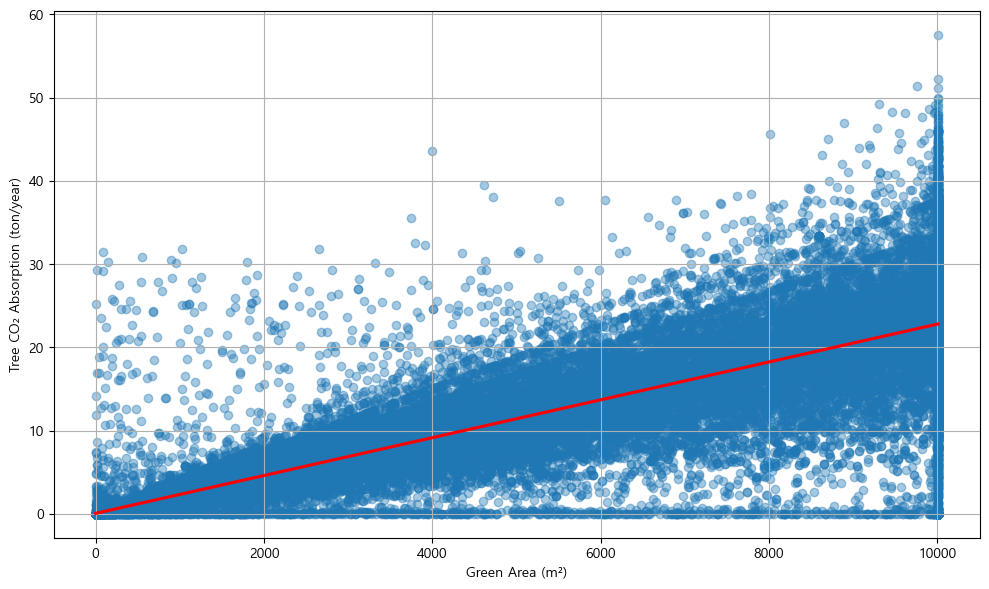

In [103]:
import seaborn as sns

# 시각화
plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged_df,
    x='green_area_m2',
    y='tree_tco2',
    line_kws={"color": "red"},   # 회귀선 색상
    scatter_kws={"alpha": 0.4}   # 산점도 투명도
)

plt.xlabel('Green Area (m²)')
plt.ylabel('Tree CO₂ Absorption (ton/year)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=grid_result, name="확인")

# 맵 출력 및 상세설정
map

#### 탄소배출량

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/12._탄소배출량_전기부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_elec = pd.json_normalize(geojson_data['features'])
emission_elec['geometry'] = emission_elec['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_elec = emission_elec.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_elec.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_elec.columns
]

# 우선 정렬: grid_cd 기준 + e_tot 큰 값 우선
emission_elec = emission_elec.sort_values(['grid_cd', 'e_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_elec.columns if col.startswith('e_')]

# groupby하여 병합
emission_elec = (
    emission_elec
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # e_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_elec = gpd.GeoDataFrame(emission_elec, geometry='geometry')

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/13._탄소배출량_가스부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_gas = pd.json_normalize(geojson_data['features'])
emission_gas['geometry'] = emission_gas['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_gas = emission_gas.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_gas.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_gas.columns
]

# 우선 정렬: grid_cd 기준 + g_tot 큰 값 우선
emission_gas = emission_gas.sort_values(['grid_cd', 'g_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_gas.columns if col.startswith('g_')]

# groupby하여 병합
emission_gas = (
    emission_gas
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # g_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_gas = gpd.GeoDataFrame(emission_gas, geometry='geometry')

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/14._탄소배출량_난방부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_heat = pd.json_normalize(geojson_data['features'])
emission_heat['geometry'] = emission_heat['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_heat = emission_heat.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_heat.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_heat.columns
]

# 우선 정렬: grid_cd 기준 + h_tot 큰 값 우선
emission_heat = emission_heat.sort_values(['grid_cd', 'h_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_heat.columns if col.startswith('h_')]

# groupby하여 병합
emission_heat = (
    emission_heat
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # h_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_heat = gpd.GeoDataFrame(emission_heat, geometry='geometry')

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/15._탄소배출량_수송부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_transport = pd.json_normalize(geojson_data['features'])
emission_transport['geometry'] = emission_transport['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_transport = emission_transport.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_transport.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_transport.columns
]

# 우선 정렬: grid_cd 기준 + road_tco2 큰 값이 먼저 오도록
emission_transport = emission_transport.sort_values(['grid_cd', 'road_tco2'], ascending=[True, False])

# groupby하여 통합
emission_transport = (
    emission_transport
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # road_tco2가 큰 값의 gbn을 가져오기 위해 정렬한 상태에서 first
        'road_tco2': 'sum',
        'geometry': 'first'  # 어차피 동일
    })
)

emission_transport = gpd.GeoDataFrame(emission_transport, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=emission_elec[emission_elec['e_tot']<100000], name="확인")

# 맵 출력 및 상세설정
map

#### 토지이용계획도

In [19]:
areaplan = gpd.read_file('SBJ_2504_001/11._토지이용계획도.geojson', encoding='euc-kr')

areaplan = gpd.GeoDataFrame(areaplan, geometry='geometry')
areaplan = areaplan[['zoneName', 'blockName', 'blockType', 'geometry']]

# 분석대상 & 적용대상 구분
areaplan_analysis = areaplan[areaplan['zoneName']!='광명시흥 공공주택지구']
areaplan_analysis.loc[areaplan_analysis['blockName'] == 'D42', ['blockName', 'blockType']] = ['도', '도로']
areaplan_target = areaplan[areaplan['zoneName']=='광명시흥 공공주택지구']

# 엑셀 파일 불러오기
plan_info = pd.read_excel("SBJ_2504_001/26. (참고자료) 토지이용_구역별계획.xlsx")

groupings = {
    "1": ["D2-1", "D2-2"],  # 건설호수 96, 인구 239
    "2": ["D1-1", "D1-2", "D1-3", "D1-4", "D1-5", "D1-6", "D1-7", "D1-8", "D1-9", "D1-10", "D1-11", "D1-12", "D1-13", "D1-14",
          "D2-3", "D2-4", "D2-5", "D2-6", "D2-7", "D2-8", "D2-9", "D2-10", "D2-11"],  # 971, 2428
    "3": ["BD1-1", "BD1-2", "BD2-1", "BD2-2"],  # 건설호수 161, 인구 403
}
group_values = {
    "1": {"건설호수": 96, "인구": 239},
    "2": {"건설호수": 971, "인구": 2428},
    "3": {"건설호수": 161, "인구": 403},
}

# 엑셀 데이터에 건설호수/인구 배분
plan_info["건설호수_추정"] = None
plan_info["인구_추정"] = None

for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값 없는 그룹은 생략

    subset = plan_info[plan_info["구역"].isin(zones)].copy()
    total_area = subset["면적"].sum()
    if total_area == 0:
        continue

    # 비율 계산
    area_ratio = subset["면적"] / total_area
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"] = (area_ratio * group_values[group]["건설호수"]).round().astype("Int64")
    plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"] = (area_ratio * group_values[group]["인구"]).round().astype("Int64")

# 기존 코드 이후에 이 블록만 추가
for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값이 없는 그룹은 생략

    # 건설호수_추정 → 건설호수, 인구_추정 → 인구
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수"] = plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"]
    plan_info.loc[plan_info["구역"].isin(zones), "인구"] = plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"]

# 필요한 열만 선택
columns_to_merge = ['구역', '면적', '건설호수', '인구', '주택유형']
plan_info = plan_info[columns_to_merge]

# 병합 수행 ('blockName' <-> '구역' 기준, left join으로 기존 areaplan_target에 추가 열 붙이기)
areaplan_target = areaplan_target.merge(plan_info, how='left', left_on='blockName', right_on='구역')
areaplan_target['건설호수'] = areaplan_target['건설호수'].astype('Int64')
areaplan_target['인구'] = areaplan_target['인구'].astype('Int64')

# 불필요한 '구역' 열 제거 (원하는 경우)
areaplan_target.drop(columns='구역', inplace=True)

In [35]:
areaplan_analysis['zoneName'].unique()

array(['화성동탄지구 택지개발사업', '화성동탄2지구 택지개발예정지구', '위례 택지개발사업 개발계획',
       '인천경제자유구역 청라국제도시', '하남미사 공공주택지구 조성사업'], dtype=object)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



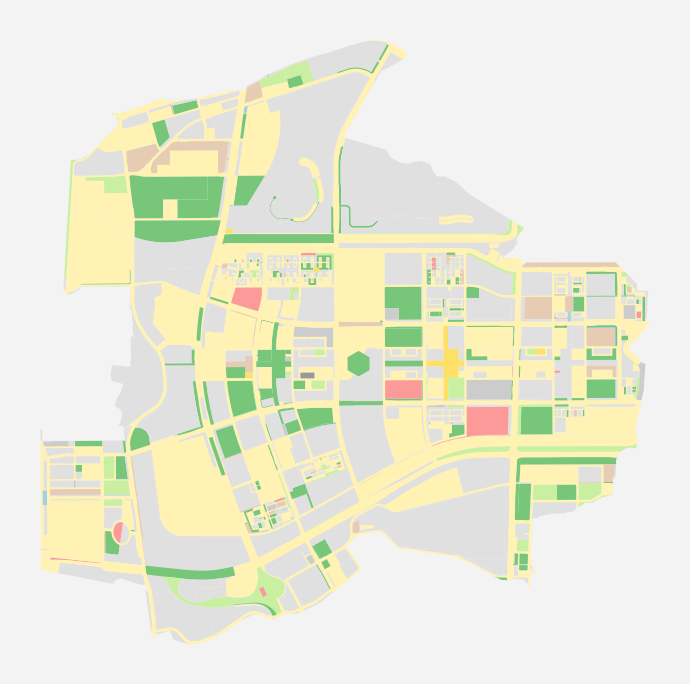

In [47]:
# 시각화
# 색상 매핑 (필요에 따라 추가/수정)
color_dict = {
    '단독주택': '#fff2b2',
    '공동주택': '#ffe066',
    '공원': '#c9f0a0',
    '녹지': '#78c679',
    '도로': '#cccccc',
    '철도시설용지': '#999999',
    '하천': '#a6cee3',
    '공공청사': '#1f78b4',
    '종교시설': '#cab2d6',
    '업무시설': '#fb9a99',
    '교육시설': '#66c2a5',
    '주차장': '#e6ccb3'
}


# 기본값 회색으로 설정
areaplan_analysis['color'] = areaplan_analysis['blockType'].map(color_dict).fillna('#e0e0e0')
fig, ax = plt.subplots(figsize=(7, 7), facecolor='#f4f3f3')
ax.set_facecolor('#f4f3f3')

areaplan_analysis[areaplan_analysis['zoneName']=='인천경제자유구역 청라국제도시'].plot(color=areaplan_analysis['color'], ax=ax)

ax.axis('off')
plt.tight_layout()
plt.show()

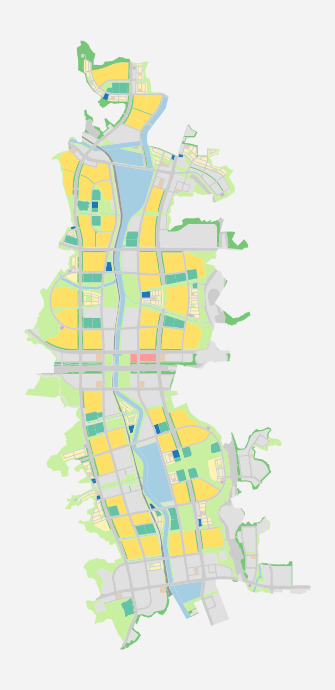

In [ ]:
# 시각화
# 색상 매핑 (필요에 따라 추가/수정)
color_dict = {
    '단독주택': '#fff2b2',
    '공동주택': '#ffe066',
    '공원': '#c9f0a0',
    '녹지': '#78c679',
    '도로': '#cccccc',
    '철도시설용지': '#999999',
    '하천': '#a6cee3',
    '공공청사': '#1f78b4',
    '종교시설': '#cab2d6',
    '업무시설': '#fb9a99',
    '교육시설': '#66c2a5',
    '주차장': '#e6ccb3'
}


# 기본값 회색으로 설정
areaplan_target['color'] = areaplan_target['blockType'].map(color_dict).fillna('#e0e0e0')
fig, ax = plt.subplots(figsize=(7, 7), facecolor='#f4f3f3')
ax.set_facecolor('#f4f3f3')

areaplan_target.plot(color=areaplan_target['color'], ax=ax)
ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# 맵 객체 생성 및 데이터 로드
areaplan_map = KeplerGl(height=1000, width=1500)
areaplan_map.add_data(data=areaplan_analysis, name="분석대상지 데이터")
areaplan_map.add_data(data=areaplan_target, name="적용대상지 데이터")

# 맵 출력 및 상세설정
areaplan_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\user\anaconda3\envs\GIS\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(data={'분석대상지 데이터': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…